In [1]:
#Importing libraries
from functools import partial
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import jinja2

import sys
if '../cmds/' not in sys.path:
    sys.path.append('../cmds/')
import warnings
warnings.filterwarnings("ignore")



/Users/nidhi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
#Helper Function
def summary_statistics_annualized(returns, annual_factor = 12):
    """This functions returns the summary statistics for the input total/excess returns passed
    into the function"""
    
    summary_statistics = pd.DataFrame(index=returns.columns)
    summary_statistics['Mean'] = returns.mean() * annual_factor
    summary_statistics['Vol'] = returns.std() * np.sqrt(annual_factor)
    summary_statistics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annual_factor)
    summary_statistics['Skewness'] = returns.skew()
    
    return summary_statistics

In [3]:
#Reading the data
barnstable_data = pd.read_excel("/Users/nidhi/Desktop/Portfolio Risk Managment/barnstable_analysis_data.xlsx",sheet_name = 'data').set_index('date')

In [6]:
#Creating excess returns column
barnstable_data['excess_returns'] = barnstable_data['SPX'] - barnstable_data['TB1M'] 
rets = barnstable_data['excess_returns']
barnstable_data.head()

,SPX,TB1M,excess_returns
date,,,
1926-01-30,-0.001783,0.003061,-0.004844
1926-02-27,-0.033297,0.002612,-0.035909
1926-03-31,-0.057708,0.002601,-0.060309
1926-04-30,0.038522,0.002270,0.036252
1926-05-28,0.013623,0.002691,0.010932


In [7]:
#Reporting summary statistics

agg_years = [(1965, 1999), (2000, 2024), (1926, 2024)]
def calc_analytics_by_year(data, agg_years):
    res = []
    for y in agg_years:
        sub = data.loc[str(y[0]):str(y[1])]
        res.append({'mean': sub.mean() * 12, 'vol': sub.std() * np.sqrt(12)})
    return pd.DataFrame(res, index = [f'{i[0]} - {i[1]}' for i in agg_years]).stack()

sum_stats = barnstable_data.apply(calc_analytics_by_year, agg_years = agg_years).T
log_sum_stats = np.log(1 + barnstable_data).apply(calc_analytics_by_year, agg_years = agg_years).T

res_stats = pd.concat([sum_stats, log_sum_stats])
res_stats.index = pd.MultiIndex.from_product([['levels','logs'], sum_stats.index.to_list()])
res_stats.style.format('{:,.2%}')






b) The full sample estimates are 



SPX underperforming RF in the next 15 years after 1999: 7.16%
SPX underperforming RF in the next 30 years after 1999: 1.92%


<Axes: >

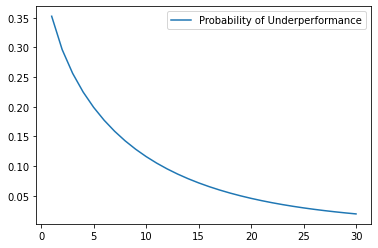

In [9]:
#Question 2

#Calculating the probability that market return is less than risk free return - this is to know when the market has been underperforming
from scipy.stats import norm
#We first define a function for standard normal function
def prob(mu,sigma,h):
    return norm.cdf(np.sqrt(h)*mu/sigma)

#The sample we include is 1965-1999
mu, sigma = res_stats['1965 - 1999'].loc[('logs', 'excess_returns')]

print(f'SPX underperforming RF in the next 15 years after 1999: {prob(mu = -mu, sigma = sigma, h = 15):,.2%}')

print(f'SPX underperforming RF in the next 30 years after 1999: {prob(mu = -mu, sigma = sigma, h = 30):,.2%}')

h = np.arange(30) + 1
probs = pd.DataFrame([prob(-mu, sigma, x) for x in h], columns=['Probability of Underperformance'], index = h)
probs.plot()









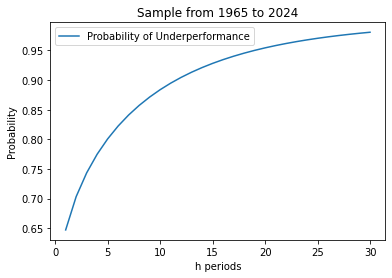

In [27]:
#Calculating the probability of underperformance for new time horizon - 1965 - 2024
mu = np.log(1+rets.loc['1965':'2024']).mean() * 12
sigma = np.log(1+rets.loc['1965':'2024']).std() * np.sqrt(12)

h = np.arange(30)+1

probs = pd.DataFrame([prob(mu, sigma, x) for x in h], columns=['Probability of Underperformance'], index = h)
probs.plot(title = 'Sample from 1965 to 2024', ylabel = 'Probability', xlabel = 'h periods')
plt.show()


In [26]:
#Question 4
import math
mu = (res_stats[('1965 - 1999', 'mean')].loc[('logs', 'SPX')] - res_stats[('2000 - 2024', 'mean')].loc[('logs', 'SPX')])
sigma = (res_stats[('1965 - 1999', 'vol')].loc[('logs', 'SPX')])

print(f"Probability of underperformance in 2000-2024: {prob(-mu, sigma, 25):,.2%}")

Probability of underperformance in 2000-2024: 7.85%
